<a href="https://colab.research.google.com/github/mmc7676/Classification-Predicting-Winners-Using-538-Elo-and-Carmelo/blob/master/538_Elo_Data_Direct_Pull_and_Shaping_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting The NBA Playoffs

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('https://projects.fivethirtyeight.com/nba-model/nba_elo.csv')
df['date'] = pd.to_datetime(df['date'])
df['team1margin'] = round(df.apply(lambda row: row.score1 - row.score2, axis=1))
df['team2margin'] = round(df.apply(lambda row: row.score2 - row.score1, axis=1))
df['team1playoff'] = df.apply(lambda row: row.playoff, axis=1)
df['team2playoff'] = df.apply(lambda row: row.playoff, axis=1)
df['home1'] = df.apply(lambda row: row.team1, axis=1)
df['home2'] = df.apply(lambda row: row.team2, axis=1)
df['away1'] = df.apply(lambda row: row.team2, axis=1)
df['away2'] = df.apply(lambda row: row.team1, axis=1)
df = df.drop(['playoff'], axis = 1)
df.info() # checking tpes for variables
# initially need date temporal to create a variable, but will be changing back to object, using to concatenate for a uniquekey/row-index
# creates margins for each team

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69636 entries, 0 to 69635
Data columns (total 31 columns):
date              69636 non-null datetime64[ns]
season            69636 non-null int64
neutral           69636 non-null int64
team1             69636 non-null object
team2             69636 non-null object
elo1_pre          69636 non-null float64
elo2_pre          69636 non-null float64
elo_prob1         69636 non-null float64
elo_prob2         69636 non-null float64
elo1_post         69377 non-null float64
elo2_post         69377 non-null float64
carm-elo1_pre     6479 non-null float64
carm-elo2_pre     6479 non-null float64
carm-elo_prob1    6479 non-null float64
carm-elo_prob2    6479 non-null float64
carm-elo1_post    6220 non-null float64
carm-elo2_post    6220 non-null float64
raptor1_pre       2542 non-null float64
raptor2_pre       2542 non-null float64
raptor_prob1      2542 non-null float64
raptor_prob2      2542 non-null float64
score1            69377 non-null float6

In [2]:
keep_cols=df.columns[0:3]
keep_cols=list(keep_cols)
keep_cols2=df.columns[4:len(df.columns)]
cols_team1=[j for j in keep_cols2 if '1' in j]
cols_team2=[j for j in keep_cols2 if '2' in j]
cols_team1=keep_cols+cols_team1
cols_team2=keep_cols+cols_team2
team1_sub=df.loc[:,cols_team1]
team2_sub=df.loc[:,cols_team2]
team1_sub.columns=[n.replace('1','') for n in cols_team1]
team2_sub.columns=[n.replace('2','') for n in cols_team2]
print(team1_sub.head())
print(team2_sub.head())
final_df=pd.concat([team1_sub,team2_sub])

        date  season  neutral  elo_pre  ...  teammargin  teamplayoff  home  away
0 1946-11-01    1947        0   1300.0  ...        -2.0          NaN   TRH   NYK
1 1946-11-02    1947        0   1300.0  ...        16.0          NaN   CHS   NYK
2 1946-11-02    1947        0   1300.0  ...         6.0          NaN   PRO   BOS
3 1946-11-02    1947        0   1300.0  ...         5.0          NaN   STB   PIT
4 1946-11-02    1947        0   1300.0  ...       -17.0          NaN   DTF   WSC

[5 rows x 16 columns]
        date  season  neutral team  ...  teammargin  teamplayoff  home  away
0 1946-11-01    1947        0  NYK  ...         2.0          NaN   NYK   TRH
1 1946-11-02    1947        0  NYK  ...       -16.0          NaN   NYK   CHS
2 1946-11-02    1947        0  BOS  ...        -6.0          NaN   BOS   PRO
3 1946-11-02    1947        0  PIT  ...        -5.0          NaN   PIT   STB
4 1946-11-02    1947        0  WSC  ...        17.0          NaN   WSC   DTF

[5 rows x 17 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
final_df['team'].value_counts()

BOS    3126
NYK    3118
LAL    2724
DET    2662
PHI    2534
       ... 
DTF      30
INJ      29
DNN      28
CHP      26
SDS       8
Name: team, Length: 102, dtype: int64

As we can see, there is way too much data here.  The league has changed so much since then and franchises are different.

# 2014-2015 was first full season with all current teams and after lockout
*Going to try to use this is a starting point with the new dataset made for each team in a game in a season

In [0]:
final_df = final_df[final_df['season'] >= 2015]

In [5]:
# this number is how many points the winners beat the losers by, but is actually a function of team games with zero sum outcomes
final_df.groupby('season')['teammargin'].count().sort_values(
    ascending = True)

season
2020    1942
2017    2618
2015    2622
2018    2624
2019    2624
2016    2632
Name: teammargin, dtype: int64

In [6]:
# to work on the teamplayoff variable-incomplete in import
pd.pivot_table(final_df, values='teammargin', 
               index=['season', 'home', 'teamplayoff'], 
                   aggfunc = np.count_nonzero)

teammargin
season home teamplayoff            
2015   ATL  t                  16.0
       BOS  t                   4.0
       BRK  t                   6.0
       CHI  t                  12.0
       CLE  t                  20.0
...                             ...
2019   TOR  c                   6.0
            f                   6.0
            q                   5.0
            s                   7.0
       UTA  q                   5.0

[136 rows x 1 columns]

In [0]:
# 2014-2015 was first full season with all current teams and after lockout
final_df = final_df[final_df['season'] >= 2015]

In [0]:
final_df['teamplayoff'].fillna(value = 0, inplace = True)

In [9]:
# this can then be binarized.  0 now is not a playoff game and the letters represent rounds of the playoffs
final_df['teamplayoff'].value_counts()

0    14760
q      348
s      174
t      162
c       92
f       44
Name: teamplayoff, dtype: int64

This is what I was looking for.  the variable team I created shows the number of games each team played per year and if they are playoffs/regular season.  I have all of this data that I have manually compiled while working on this project, but am going to try to produce everything from scratch from that link

In [10]:
# if add 'away' to index, can see the number and types of games the team played against during each season
pd.pivot_table(final_df, values='team', 
               index=['season', 'home', 'teamplayoff'], 
                   aggfunc = np.count_nonzero)

team
season home teamplayoff      
2015   ATL  0              82
            t              16
       BOS  0              82
            t               4
       BRK  0              82
...                       ...
2020   SAC  0              82
       SAS  0              82
       TOR  0              82
       UTA  0              82
       WAS  0              82

[316 rows x 1 columns]

In [11]:
# I am going to try t9 create variables here with code, but know the dataset.  Raptor Data started in 2018-2019, since using this and carmelo would definitely have overlap
# carmelo gives 3 mores sense for model  I will run this again, but lets look at zero variance
final_df.std()[final_df.std() == 0]
#none

Series([], dtype: float64)

In [0]:
# drop raptor
final_df = final_df.drop(['raptor_pre', 'raptor_prob'], axis = 1)

In [13]:
# looks like we need to go from 2016
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15580 entries, 61846 to 69635
Data columns (total 15 columns):
away             15580 non-null object
carm-elo_post    12440 non-null float64
carm-elo_pre     12958 non-null float64
carm-elo_prob    12958 non-null float64
date             15580 non-null datetime64[ns]
elo_post         15062 non-null float64
elo_pre          15580 non-null float64
elo_prob         15580 non-null float64
home             15580 non-null object
neutral          15580 non-null int64
score            15062 non-null float64
season           15580 non-null int64
team             7790 non-null object
teammargin       15062 non-null float64
teamplayoff      15580 non-null object
dtypes: datetime64[ns](1), float64(8), int64(2), object(4)
memory usage: 1.9+ MB


In [0]:
# lets do that and make copies to try to manually creater a variables to track games in a season and wins.  make two df copies
final_df = final_df[final_df['season'] >= 2016]
games = final_df.copy()
yrdf = final_df.copy()

In [0]:
# break up to look at data.  Going to start with 2015-2016 season because that is where carmelo data begins as mentioned-see if we neeed these later
nba16 = yrdf[yrdf['season']== 2016]
nba17 = yrdf[yrdf['season']== 2017]
nba18 = yrdf[yrdf['season']== 2018]
nba19 = yrdf[yrdf['season']== 2019]
nba20 = yrdf[yrdf['season']== 2020]
# will also be dropping raptor

In [0]:
# this creates the team variable for 1 for each game and I am using the rest for an index key
# I want to keep the games['team'] variable because it is signifies a game played we can use for running count
games = pd.pivot_table(games, values='team', index=['season', 'home','date'], aggfunc = np.count_nonzero)

In [17]:
games.describe().T

,count,mean,std,min,25%,50%,75%,max
team,12958.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [18]:
games.head()

team
season home date            
2016   ATL  2015-10-27     1
            2015-10-29     1
            2015-10-30     1
            2015-11-01     1
            2015-11-03     1

In [0]:
# drop the index levels so we can concatenate the rest to create our unique key
games.reset_index(level=0, inplace=True)

In [20]:
games.head()

season  team
home date                    
ATL  2015-10-27    2016     1
     2015-10-29    2016     1
     2015-10-30    2016     1
     2015-11-01    2016     1
     2015-11-03    2016     1

In [21]:
games.reset_index(level=0, inplace=True)
games.head()

,home,season,team
date,,,
2015-10-27,ATL,2016,1
2015-10-29,ATL,2016,1
2015-10-30,ATL,2016,1
2015-11-01,ATL,2016,1
2015-11-03,ATL,2016,1


In [22]:
# now this is an unindex df
games.reset_index(level=0, inplace=True)
games.head()

,date,home,season,team
0,2015-10-27,ATL,2016,1
1,2015-10-29,ATL,2016,1
2,2015-10-30,ATL,2016,1
3,2015-11-01,ATL,2016,1
4,2015-11-03,ATL,2016,1


In [0]:
# create unique index key for the df
games['key'] = games.date.map(str) + "_" + games.home.map(str)

In [24]:
# because the 2016-2019 seasons have been played and we have the data from above, this is what the model will be built on.
# the 2020 season actually has data that we can see if our model does predict well if/when the nba comes back
data_2020 = yrdf[yrdf['season'] == 2020]
yrdf = yrdf[yrdf['season'] < 2020]
yrdf.info()
# now could be a good time to export the data to csv's for back up

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10498 entries, 63157 to 68405
Data columns (total 15 columns):
away             10498 non-null object
carm-elo_post    10498 non-null float64
carm-elo_pre     10498 non-null float64
carm-elo_prob    10498 non-null float64
date             10498 non-null datetime64[ns]
elo_post         10498 non-null float64
elo_pre          10498 non-null float64
elo_prob         10498 non-null float64
home             10498 non-null object
neutral          10498 non-null int64
score            10498 non-null float64
season           10498 non-null int64
team             5249 non-null object
teammargin       10498 non-null float64
teamplayoff      10498 non-null object
dtypes: datetime64[ns](1), float64(8), int64(2), object(4)
memory usage: 1.3+ MB


I am working to get this in shape...

In [0]:
# now do the same with the 2016-2019 full data-create key
yrdf['key'] = yrdf['key'] = yrdf.date.map(str) + "_" + yrdf.home.map(str)

In [0]:
# I am going to dropdrop  home, season, and date team because i have them in the games df which can be joined by keys
# merging the two datasets.  The key will work regardless because is it unique
#games = games.drop(['home'], axis = 1)
yrdf = yrdf.drop(['team','date', 'home', 'season'], axis = 1)

In [27]:
# we can now drop the team column from yrdf so all records will be balanced
# lets look at the columns as values
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12958 entries, 0 to 12957
Data columns (total 5 columns):
date      12958 non-null datetime64[ns]
home      12958 non-null object
season    12958 non-null int64
team      12958 non-null int64
key       12958 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 506.3+ KB


In [28]:
nba1619 = pd.merge(games,yrdf, how = 'inner', on='key') # we will see dupes for home date and season
nba1619.head()

,date,home,season,team,key,away,carm-elo_post,carm-elo_pre,carm-elo_prob,elo_post,elo_pre,elo_prob,neutral,score,teammargin,teamplayoff
0,2015-10-27,ATL,2016,1,2015-10-27 00:00:00_ATL,DET,1521.809995,1542.664875,0.755572,1541.296352,1561.843550,0.748850,0,94.0,-12.0,0
1,2015-10-29,ATL,2016,1,2015-10-29 00:00:00_ATL,NYK,1528.727629,1521.809995,0.657430,1549.123263,1541.296352,0.620346,0,112.0,11.0,0
2,2015-10-30,ATL,2016,1,2015-10-30 00:00:00_ATL,CHO,1532.229012,1528.727629,0.658312,1551.128167,1549.123263,0.787977,0,97.0,3.0,0
3,2015-11-01,ATL,2016,1,2015-11-01 00:00:00_ATL,CHO,1537.645363,1532.229012,0.453917,1555.405687,1551.128167,0.546010,0,94.0,2.0,0
4,2015-11-03,ATL,2016,1,2015-11-03 00:00:00_ATL,MIA,1546.625792,1537.645363,0.439085,1564.073886,1555.405687,0.453913,0,98.0,6.0,0


In [29]:
# now it may be easier to follow what I was doing.  we have the 15-16, 16-17, 17-18, and 18-19 seasons with matching data now
nba1619.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10498 entries, 0 to 10497
Data columns (total 16 columns):
date             10498 non-null datetime64[ns]
home             10498 non-null object
season           10498 non-null int64
team             10498 non-null int64
key              10498 non-null object
away             10498 non-null object
carm-elo_post    10498 non-null float64
carm-elo_pre     10498 non-null float64
carm-elo_prob    10498 non-null float64
elo_post         10498 non-null float64
elo_pre          10498 non-null float64
elo_prob         10498 non-null float64
neutral          10498 non-null int64
score            10498 non-null float64
teammargin       10498 non-null float64
teamplayoff      10498 non-null object
dtypes: datetime64[ns](1), float64(8), int64(3), object(4)
memory usage: 1.4+ MB


In [0]:
# clean up type
nba1619['teammargin'] = nba1619.teammargin.map(int)
nba1619['score'] = nba1619.score.map(int)

In [31]:
nba1619.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10498 entries, 0 to 10497
Data columns (total 16 columns):
date             10498 non-null datetime64[ns]
home             10498 non-null object
season           10498 non-null int64
team             10498 non-null int64
key              10498 non-null object
away             10498 non-null object
carm-elo_post    10498 non-null float64
carm-elo_pre     10498 non-null float64
carm-elo_prob    10498 non-null float64
elo_post         10498 non-null float64
elo_pre          10498 non-null float64
elo_prob         10498 non-null float64
neutral          10498 non-null int64
score            10498 non-null int64
teammargin       10498 non-null int64
teamplayoff      10498 non-null object
dtypes: datetime64[ns](1), float64(6), int64(5), object(4)
memory usage: 1.4+ MB


In [0]:
# add if team won game  I am trying to get a binary 1/0 hear
nba1619['win']= nba1619.loc[nba1619['team'] > 0].sum(axis=1).where(nba1619['teammargin'] > 0, 0)

In [33]:
# It didn't work, but has to b fxiable I jusy nead to binarize any value greater than 1
nba1619.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10458,10459,10460,10461,10462,10463,10464,10465,10466,10467,10468,10469,10470,10471,10472,10473,10474,10475,10476,10477,10478,10479,10480,10481,10482,10483,10484,10485,10486,10487,10488,10489,10490,10491,10492,10493,10494,10495,10496,10497
date,2015-10-27 00:00:00,2015-10-29 00:00:00,2015-10-30 00:00:00,2015-11-01 00:00:00,2015-11-03 00:00:00,2015-11-04 00:00:00,2015-11-06 00:00:00,2015-11-07 00:00:00,2015-11-09 00:00:00,2015-11-11 00:00:00,2015-11-13 00:00:00,2015-11-15 00:00:00,2015-11-17 00:00:00,2015-11-18 00:00:00,2015-11-21 00:00:00,2015-11-24 00:00:00,2015-11-25 00:00:00,2015-11-27 00:00:00,2015-11-28 00:00:00,2015-11-30 00:00:00,2015-12-02 00:00:00,2015-12-04 00:00:00,2015-12-09 00:00:00,2015-12-10 00:00:00,2015-12-12 00:00:00,2015-12-14 00:00:00,2015-12-16 00:00:00,2015-12-18 00:00:00,2015-12-20 00:00:00,2015-12-21 00:00:00,2015-12-23 00:00:00,2015-12-26 00:00:00,2015-12-28 00:00:00,2015-12-29 00:00:00,2016-01-03 00:00:00,2016-01-05 00:00:00,2016-01-07 00:00:00,2016-01-09 00:00:00,2016-01-13 00:00:00,2016-01-15 00:00:00,...,2019-01-11 00:00:00,2019-01-13 00:00:00,2019-01-17 00:00:00,2019-01-21 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-27 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-02-02 00:00:00,2019-02-04 00:00:00,2019-02-06 00:00:00,2019-02-08 00:00:00,2019-02-09 00:00:00,2019-02-11 00:00:00,2019-02-13 00:00:00,2019-02-22 00:00:00,2019-02-23 00:00:00,2019-02-27 00:00:00,2019-03-01 00:00:00,2019-03-03 00:00:00,2019-03-06 00:00:00,2019-03-08 00:00:00,2019-03-09 00:00:00,2019-03-11 00:00:00,2019-03-13 00:00:00,2019-03-15 00:00:00,2019-03-16 00:00:00,2019-03-18 00:00:00,2019-03-20 00:00:00,2019-03-21 00:00:00,2019-03-23 00:00:00,2019-03-26 00:00:00,2019-03-27 00:00:00,2019-03-29 00:00:00,2019-03-31 00:00:00,2019-04-03 00:00:00,2019-04-05 00:00:00,2019-04-07 00:00:00,2019-04-09 00:00:00
home,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,...,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS,WAS
season,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019,2019
team,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
key,2015-10-27 00:00:00_ATL,2015-10-29 00:00:00_ATL,2015-10-30 00:00:00_ATL,2015-11-01 00:00:00_ATL,2015-11-03 00:00:00_ATL,2015-11-04 00:00:00_ATL,2015-11-06 00:00:00_ATL,2015-11-07 00:00:00_ATL,2015-11-09 00:00:00_ATL,2015-11-11 00:00:00_ATL,2015-11-13 00:00:00_ATL,2015-11-15 00:00:00_ATL,2015-11-17 00:00:00_ATL,2015-11-18 00:00:00_ATL,2015-11-21 00:00:00_ATL,2015-11-24 00:00:00_ATL,2015-11-25 00:00:00_ATL,2015-11-27 00:00:00_ATL,2015-11-28 00:00:00_ATL,2015-11-30 00:00:00_ATL,2015-12-02 00:00:00_ATL,2015-12-04 00:00:00_ATL,2015-12-09 00:00:00_ATL,2015-12-10 00:00:00_ATL,2015-12-12 00:00:00_ATL,2015-12-14 00:00:00_ATL,2015-12-16 00:00:00_ATL,2015-12-18 00:00:00_ATL,2015-12-20 00:00:00_ATL,2015-12-21 00:00:00_ATL,2015-12-23 00:00:00_ATL,2015-12-26 00:00:00_ATL,2015-12-28 00:00:00_ATL,2015-12-29 00:00:00_ATL,2016-01-03 00:00:00_ATL,2016-01-05 00:00:00_ATL,2016-01-07 00:00:00_ATL,2016-01-09 00:00:00_ATL,2016-01-13 00:00:00_ATL,2016-01-15 00:00:00_ATL,...,2019-01-11 00:00:00_WAS,2019-01-13 00:00:00_WAS,2019-01-17 00:00:00_WAS,2019-01-21 00:00:00_WAS,2019-01-24 00:00:00_WAS,2019-01-25 00:00:00_WAS,2019-01-27 00:0

In [0]:
nba = nba1619.copy()

In [0]:
def make_playoffs(team, season):
    begin = 0
    for season in df:
        while df['season'][season] == season:
            gamecount = (begin + df['home'][team]).sum()
            if gamecount > 82:
                j = 'Yes'
            else:
                j = 'No'
    return j
    

# At this point, I need to use some of the data I already pulled and preprocesed.  It was all tasken using python and NBA knowledge.
I have an extraordinary amount of data that I have been using for other parts of this, but need to build the model for this project

In [0]:
#def fix_win(df):
 #   zo = 0
  #  for j in col:
   #     if j >= 1:
    #        col[j] = 1
   # return

# Visualizations

In [0]:
import matplotlib.pyplot as plt 
import seaborn as sns 

I think I have explored the variables a bunch, but want to do it visually now

In [43]:
#team variable is stil going to try to be used
nba.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10498.0,2017.499143,1.118683,2016.000000,2016.000000,2017.000000,2018.000000,2019.000000
team,10498.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
carm-elo_post,10498.0,1513.699507,118.329616,1187.730784,1438.737242,1513.640139,1588.756279,1881.619599
carm-elo_pre,10498.0,1513.699507,118.126811,1187.730784,1438.773201,1513.640139,1588.549394,1881.619599
carm-elo_prob,10498.0,0.500000,0.229883,0.013407,0.313235,0.500000,0.686765,0.986593
elo_post,10498.0,1512.693498,111.969518,1194.291572,1438.447882,1515.182470,1584.840106,1865.449075
elo_pre,10498.0,1512.693498,111.640863,1194.291572,1438.627416,1515.251930,1584.294419,1865.449075
elo_prob,10498.0,0.500000,0.218765,0.018315,0.325188,0.500000,0.674812,0.981685
neutral,10498.0,0.002096,0.045732,0.000000,0.000000,0.000000,0.000000,1.000000
score,10498.0,106.324633,12.549575,64.000000,98.000000,106.000000,115.000000,168.000000


In [44]:
nba['neutral'].value_counts

<bound method IndexOpsMixin.value_counts of 0        0
1        0
2        0
3        0
4        0
        ..
10493    0
10494    0
10495    0
10496    0
10497    0
Name: neutral, Length: 10498, dtype: int64>

In [0]:
# this appears to be insignificant
nba = nba.drop(['neutral'], axis = 1)

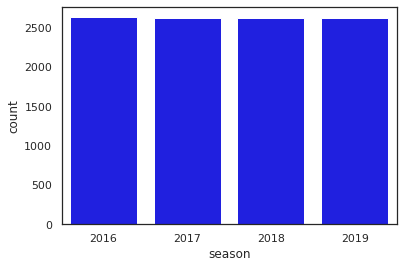

In [46]:
# this is all games for all teams over the four years.  2017 is less because this includes playoffs
sns.set(style="white") 

ax = sns.countplot(x='season', data = nba,
                  color = 'blue') 

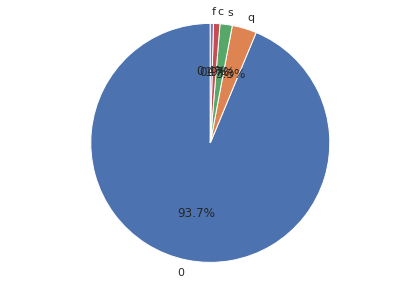

In [47]:
#to show distribution of playoffs versus regular season
fig1, ax1 = plt.subplots()


# gives the categories and the number of instances in each category
x = list(nba['teamplayoff'].value_counts().index) 
y = list(nba['teamplayoff'].value_counts())
ax1.pie(y, labels = x, autopct='%1.1f%%', startangle=90)
ax1.axis('equal') 
plt.tight_layout()  

plt.show() 

# Above 0 is regular season, q is conference quarterfinals, s is conference semifinals, c is confeence finals, f is nba finals


I think the best thing to do with this data is to drop the playoffs and use this data to make a classification model on whether a team will make the playoffs versus the ratings indices and probabilties of winning that game.

The indices are designed for different reasons
Elo tracks a teams recent performance.  It doesn't take in to account things like players being traded or injuries. An example of this I came across was a big drop in the Cleveland Cavaliers Carmelo rating for 2018-2019 (sum of parts for players) and the elo rating which still factored in the end of the 2017-2018 seasons.  The Los Angeles Lakers, the team he went to, behaved oppositely.  I will try to chart by distribution.  Elo pre is before the game.  Elo post is after the game.  Carmelo pre is before the game.  This sin't over time, but you can see how one player shifts the entire distribution

In [0]:
cavs = nba[nba['home']=='CLE']

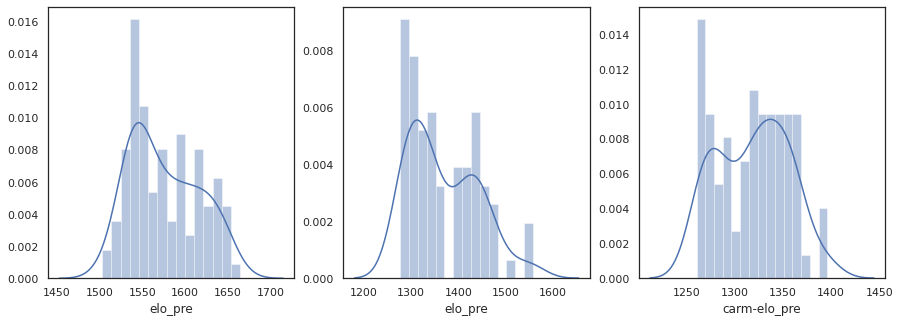

In [49]:
plt.figure(figsize=(15,5))# changes size  5 y axis 15 x axis

plt.subplot(131)
sns.distplot(cavs.loc[cavs['season'] == 2018, 'elo_pre'], bins = 15)

plt.subplot(132)
sns.distplot(cavs.loc[cavs['season'] == 2019, 'elo_pre'], bins = 15)

plt.subplot(133)
sns.distplot(cavs.loc[cavs['season'] == 2019, 'carm-elo_pre'], bins = 15)

I need to export the data and will import it back in

In [0]:
nba.to_csv('mis636nbafinal.csv')

In [51]:
nba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10498 entries, 0 to 10497
Data columns (total 16 columns):
date             10498 non-null datetime64[ns]
home             10498 non-null object
season           10498 non-null int64
team             10498 non-null int64
key              10498 non-null object
away             10498 non-null object
carm-elo_post    10498 non-null float64
carm-elo_pre     10498 non-null float64
carm-elo_prob    10498 non-null float64
elo_post         10498 non-null float64
elo_pre          10498 non-null float64
elo_prob         10498 non-null float64
score            10498 non-null int64
teammargin       10498 non-null int64
teamplayoff      10498 non-null object
win              10498 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(4), object(4)
memory usage: 1.7+ MB


# While looking at this I see the merge from the other file didn't work.

# I will do a merge with the other data so I can run these models